In [104]:
!pip install mlflow

In [105]:
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
import shutil
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import shutil
import mlflow

In [106]:
if os.path.exists('data'):
  shutil.rmtree('data')

In [107]:
!kaggle datasets download -d ghostbat101/lung-x-ray-image-clinical-text-dataset -p data

Dataset URL: https://www.kaggle.com/datasets/ghostbat101/lung-x-ray-image-clinical-text-dataset
License(s): MIT
 99% 1.31G/1.33G [00:06<00:00, 214MB/s]
100% 1.33G/1.33G [00:06<00:00, 234MB/s]


In [108]:
!unzip -n data/lung-x-ray-image-clinical-text-dataset.zip -d data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/Merged Data (image+text)/Obstructive Pulmonary Diseases/image_45915.jpg  
  inflating: data/Merged Data (image+text)/Obstructive Pulmonary Diseases/image_4592.jpg  
  inflating: data/Merged Data (image+text)/Obstructive Pulmonary Diseases/image_45950.jpg  
  inflating: data/Merged Data (image+text)/Obstructive Pulmonary Diseases/image_45951.jpg  
  inflating: data/Merged Data (image+text)/Obstructive Pulmonary Diseases/image_45952.jpg  
  inflating: data/Merged Data (image+text)/Obstructive Pulmonary Diseases/image_45953.jpg  
  inflating: data/Merged Data (image+text)/Obstructive Pulmonary Diseases/image_45956.jpg  
  inflating: data/Merged Data (image+text)/Obstructive Pulmonary Diseases/image_45957.jpg  
  inflating: data/Merged Data (image+text)/Obstructive Pulmonary Diseases/image_45961.jpg  
  inflating: data/Merged Data (image+text)/Obstructive Pulmonary Diseases/image_45964.jpg  
  i

On remplace les espaces par _ dans les noms des dossiers et fichiers

In [109]:
def replace_spaces_with_underscores(directory):
    for root, dirs, files in os.walk(directory, topdown=False):
        for name in dirs:
            new_name = name.replace(' ', '_')
            if new_name != name:
                old_path = os.path.join(root, name)
                new_path = os.path.join(root, new_name)
                shutil.move(old_path, new_path)
                print(f"Renamed: {old_path} -> {new_path}")

replace_spaces_with_underscores('data')


Renamed: data/Main dataset/Degenerative Infectious Diseases -> data/Main dataset/Degenerative_Infectious_Diseases
Renamed: data/Main dataset/Mediastinal Changes -> data/Main dataset/Mediastinal_Changes
Renamed: data/Main dataset/Obstructive Pulmonary Diseases -> data/Main dataset/Obstructive_Pulmonary_Diseases
Renamed: data/Main dataset/Lower Density -> data/Main dataset/Lower_Density
Renamed: data/Main dataset/Chest Changes -> data/Main dataset/Chest_Changes
Renamed: data/Main dataset/Higher Density -> data/Main dataset/Higher_Density
Renamed: data/Main dataset/Encapsulated Lesions -> data/Main dataset/Encapsulated_Lesions
Renamed: data/Merged Data (image+text)/Degenerative Infectious Diseases -> data/Merged Data (image+text)/Degenerative_Infectious_Diseases
Renamed: data/Merged Data (image+text)/Mediastinal Changes -> data/Merged Data (image+text)/Mediastinal_Changes
Renamed: data/Merged Data (image+text)/Obstructive Pulmonary Diseases -> data/Merged Data (image+text)/Obstructive_Pul

On met de côté 20 % des données pour le test

In [110]:
# Chemin vers le dataset principal
source_dir = "data/Main_dataset"

# Chemin vers le dossier où les 20% seront stockés
test_dir = "data/Test_dataset"

# Fraction des données à extraire
test_split = 0.2

# Définir un seed pour rendre le tirage aléatoire reproductible
random.seed(42)

# Créer le dossier de sortie
os.makedirs(test_dir, exist_ok=True)

# Parcourir chaque classe (dossier dans le dataset principal)
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):  # Vérifier que c'est un dossier
        # Lister tous les fichiers de la classe
        images = os.listdir(class_path)

        # Mélanger les fichiers aléatoirement
        random.shuffle(images)

        # Calculer le nombre de fichiers à déplacer
        num_test_files = int(len(images) * test_split)
        test_files = images[:num_test_files]

        # Créer un dossier pour cette classe dans le dossier de test
        class_test_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_test_dir, exist_ok=True)

        # Déplacer les fichiers sélectionnés
        for img in test_files:
            src_path = os.path.join(class_path, img)
            dest_path = os.path.join(class_test_dir, img)
            shutil.move(src_path, dest_path)

print(f"20% des données ont été déplacées vers le dossier '{test_dir}'")

20% des données ont été déplacées vers le dossier 'data/Test_dataset'


# Creation d'un sample avec 20 % des données : Main dataset Sample

In [111]:
# Chemin vers le dataset principal
source_dir = "data/Main_dataset"

# Chemin vers le dossier où les 20% seront copiés
test_dir = "data/Main_dataset_Sample"

# Fraction des données à extraire
main_sample = 0.2

# Définir un seed pour rendre le tirage aléatoire reproductible
random.seed(42)

# Créer le dossier de sortie pour le dataset de test
os.makedirs(test_dir, exist_ok=True)

# Parcourir chaque classe (dossier dans le dataset principal)
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    if os.path.isdir(class_path):  # Vérifier que c'est un dossier
        # Lister tous les fichiers de la classe
        images = os.listdir(class_path)

        # Mélanger les fichiers aléatoirement
        random.shuffle(images)

        # Calculer le nombre de fichiers à dupliquer
        num_sample_files = int(len(images) * main_sample)  # Correction du nom de la variable
        sample_files = images[:num_sample_files]

        # Créer un dossier pour cette classe dans le dossier de test
        class_sample_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_sample_dir, exist_ok=True)  # Correction du nom du dossier

        # Dupliquer les fichiers sélectionnés dans le dossier de test
        for img in sample_files:  # Correction de la variable test_files en sample_files
            src_path = os.path.join(class_path, img)
            dest_path = os.path.join(class_sample_dir, img)
            shutil.copy(src_path, dest_path)  # Utilisation de shutil.copy() pour dupliquer

print("Les 20% des données ont été dupliquées dans le répertoire Main dataset Sample.")

Les 20% des données ont été dupliquées dans le répertoire Main dataset Sample.


# Transformation en binaire : main dataset sample binaire et en multiclasse malade : main dataset sample multiclasse

In [112]:
# Chemin vers le dataset principal
source_dir = "data/Main_dataset_Sample"

# Chemin vers le nouveau dataset binaire
binary_sample_dir = "data/Main_dataset_Sample_Binaire"


# Créer les répertoires de sortie pour les classes "Normal" et "Malades"
os.makedirs(binary_sample_dir, exist_ok=True)
normal_dir = os.path.join(binary_sample_dir, "Normal")
malades_dir = os.path.join(binary_sample_dir, "Malades")
os.makedirs(normal_dir, exist_ok=True)
os.makedirs(malades_dir, exist_ok=True)

# Liste des classes malades
malades_classes = ['Chest_Changes', 'Degenerative_Infectious_Diseases', 'Encapsulated_Lesions',
                    'Higher_Density', 'Lower_Density', 'Mediastinal_Changes', 'Obstructive_Pulmonary_Diseases']

# Parcourir chaque classe (dossier dans le dataset principal)
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    if os.path.isdir(class_path):  # Vérifier que c'est un dossier
        # Lister tous les fichiers de la classe
        images = os.listdir(class_path)

        # Mélanger les fichiers aléatoirement
        random.shuffle(images)

        # Calculer le nombre de fichiers à dupliquer
        num_sample_files = int(len(images) * main_sample)
        sample_files = images[:num_sample_files]

        if class_name == 'Normal':
            # Créer le dossier pour la classe "Normal"
            for img in sample_files:
                src_path = os.path.join(class_path, img)
                dest_path = os.path.join(normal_dir, img)
                shutil.copy(src_path, dest_path)  # Copier l'image dans le dossier "Normal"

        elif class_name in malades_classes:
            # Créer le dossier pour les classes malades
            for img in sample_files:
                src_path = os.path.join(class_path, img)
                dest_path = os.path.join(malades_dir, img)
                shutil.copy(src_path, dest_path)  # Copier l'image dans le dossier "Malades"

print("Les données ont été dupliquées dans le répertoire Main dataset Sample Binaire avec les classes 'Normal' et 'Malades'.")

Les données ont été dupliquées dans le répertoire Main dataset Sample Binaire avec les classes 'Normal' et 'Malades'.


In [113]:

# Chemin vers le dataset principal
source_dir = "data/Main_dataset_Sample"

# Chemin vers le nouveau dataset binaire
binary_sample_dir = "data/Main_dataset_Sample_Binaire"

# Chemin vers le nouveau dataset multiclasse
multiclass_sample_dir = "data/Main_dataset_Sample_Multiclasse"

# Créer les répertoires de sortie pour les classes "Normal" et "Malades"
os.makedirs(binary_sample_dir, exist_ok=True)
normal_dir = os.path.join(binary_sample_dir, "Normal")
malades_dir = os.path.join(binary_sample_dir, "Malades")
os.makedirs(normal_dir, exist_ok=True)
os.makedirs(malades_dir, exist_ok=True)

# Créer le répertoire de sortie pour le dataset multiclasse
os.makedirs(multiclass_sample_dir, exist_ok=True)

# Liste des classes malades
malades_classes = ['Chest_Changes', 'Degenerative_Infectious_Diseases', 'Encapsulated_Lesions',
                   'Higher_Density', 'Lower_Density', 'Mediastinal_Changes', 'Obstructive_Pulmonary_Diseases']

# Parcourir chaque classe (dossier dans le dataset principal)
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    if os.path.isdir(class_path):  # Vérifier que c'est un dossier
        # Lister tous les fichiers de la classe
        images = os.listdir(class_path)

        # Mélanger les fichiers aléatoirement
        random.shuffle(images)

        # Calculer le nombre de fichiers à dupliquer
        num_sample_files = int(len(images) * main_sample)
        sample_files = images[:num_sample_files]

        # Gestion pour le dataset binaire
        if class_name == 'Normal':
            for img in sample_files:
                src_path = os.path.join(class_path, img)
                dest_path = os.path.join(normal_dir, img)
                shutil.copy(src_path, dest_path)  # Copier l'image dans le dossier "Normal"

        elif class_name in malades_classes:
            for img in sample_files:
                src_path = os.path.join(class_path, img)
                dest_path = os.path.join(malades_dir, img)
                shutil.copy(src_path, dest_path)  # Copier l'image dans le dossier "Malades"

        # Gestion pour le dataset multiclasse
        multiclass_dir = os.path.join(multiclass_sample_dir, class_name)
        os.makedirs(multiclass_dir, exist_ok=True)  # Créer un sous-dossier pour chaque classe
        for img in sample_files:
            src_path = os.path.join(class_path, img)
            dest_path = os.path.join(multiclass_dir, img)
            shutil.copy(src_path, dest_path)  # Copier l'image dans son dossier de classe

print("Les données ont été dupliquées :")
print("- Dans le répertoire Main_dataset_Sample_Binaire avec les classes 'Normal' et 'Malades'.")
print("- Dans le répertoire Main_dataset_Sample_Multiclasse avec les sous-dossiers pour chaque classe.")


Les données ont été dupliquées :
- Dans le répertoire Main_dataset_Sample_Binaire avec les classes 'Normal' et 'Malades'.
- Dans le répertoire Main_dataset_Sample_Multiclasse avec les sous-dossiers pour chaque classe.


# Démarrage du tracking MLFLOW

In [196]:
MLFLOW_SERVER_URI = 'https://david-rem-jedha-final-project-mlops.hf.space'
EXPERIMENT_NAME = 'binary' # 'binary' ou 'multi'
TRAINER = 'david' # Le prénom de la personne qui a exécuté l'entrainement
MODEL_TYPE = 'baseline_with_augmentation' # Le type de modèle utilisé

mlflow.set_tracking_uri(MLFLOW_SERVER_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.tensorflow.autolog()

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
mlflow.start_run(experiment_id = experiment.experiment_id)

<ActiveRun: >

# Preprocessing

In [197]:
# Configuration de l'ImageDataGenerator avec preprocessing_function
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels
    #preprocessing_function=preprocess_grayscale_to_rgb,  # Fonction de conversion des cqnaux
    validation_split=0.2,  # Fraction pour la validation
    #rotation_range=90,
    #brightness_range=(0.5,1),
    #shear_range=0.2,
    #zoom_range=0.2,
    #channel_shift_range=0.2,
    #horizontal_flip=True,
    #vertical_flip=True
)

In [198]:
# Chargement des ensembles
BATCH_SIZE = 64
img_size = (128,128)
seed = 42

In [199]:
# Chargement des données  de train avec flow_from_directory
img_generator_flow_train = img_generator.flow_from_directory(
    directory="data/Main_dataset_Sample_Binaire",  # chemin vers les données
    target_size=img_size,    # taille des images
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="grayscale",    # pour charger les images en niveaux de gris
    #color_mode="rgb",    # pour charger les images en niveaux de gris
    #class_mode="categorical",  # Pour une classification multi-classes
    subset="training",
    class_mode='binary',
    seed = seed
    )

Found 3684 images belonging to 2 classes.


In [200]:
# Chargement des données  de validation avec flow_from_directory
img_generator_flow_valid = img_generator.flow_from_directory(
    directory="data/Main_dataset_Sample_Binaire",
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
    #color_mode="rgb",
    color_mode="grayscale",
    subset="validation",
    #class_mode="categorical",
    #class_mode='sparse',
    class_mode='binary',
    seed= seed
    )

Found 920 images belonging to 2 classes.


# Modèle

In [201]:
CLASSES = 1
# CLASSES =7

In [202]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((128, 128, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(1, 1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(1, 1), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(512, activation="relu"),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(CLASSES, activation="sigmoid")
])

In [203]:
#model.summary()

# Entrainement

In [204]:
# Let's create a learning rate schedule to decrease the learning rate as we train the model.
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [205]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.2,
                              patience=5, min_lr=0.001)

In [206]:
# Créer un optimiseur avec le planning du taux d'apprentissage
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compiler le modèle
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [207]:
# Définir un callback d'early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte de validation
    patience=3,          # Nombre d'époques sans amélioration avant d'arrêter
    restore_best_weights=True  # Rétablir les poids du meilleur modèle
)

In [208]:
class_indices = img_generator_flow_train.class_indices
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(list(class_indices.values())),
    y=img_generator_flow_train.classes
)
class_weights = dict(enumerate(class_weights))

In [209]:
class_weights

{0: 0.5731176104542626, 1: 3.9191489361702128}

In [210]:
EPOCHS = 20

In [211]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Save path
    monitor='accuracy',        # Ensure correct metric name
    save_best_only=True,       # Save only the best model
    mode='max',                # 'max' for accuracy, 'min' for loss
    verbose=1
)

In [212]:
# Entraîner le modèle avec early stopping
history = model.fit(
    #rgb_train_generator,
    img_generator_flow_train,
    validation_data=img_generator_flow_valid , #rgb_val_generator,
    epochs=EPOCHS ,  # Plus d'époques pour laisser l'early stopping décider
    #steps_per_epoch=len(img_generator_flow_train),
    #validation_steps=len(img_generator_flow_valid),
    #callbacks=[early_stopping],
    class_weight= class_weights,
    #callbacks=[checkpoint]
    #callbacks = [reduce_lr]
)

2025/01/24 14:29:00 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/01/24 14:29:00 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4811 - loss: 0.7124

58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step - accuracy: 0.4827 - loss: 0.7115 - val_accuracy: 0.8261 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 2/20
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6448 - loss: 0.6894

58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 376ms/step - accuracy: 0.6348 - loss: 0.6896 - val_accuracy: 0.8630 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6639 - loss: 0.6942

58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.6629 - loss: 0.6940 - val_accuracy: 0.6043 - val_loss: 0.6738 - learning_rate: 0.0010
Epoch 4/20
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5271 - loss: 0.6924

58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.5328 - loss: 0.6906 - val_accuracy: 0.6804 - val_loss: 0.6526 - learning_rate: 0.0010
Epoch 5/20
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6114 - loss: 0.6676

58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.6127 - loss: 0.6675 - val_accuracy: 0.7609 - val_loss: 0.6219 - learning_rate: 0.0010
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.6961 - loss: 0.6302 - val_accuracy: 0.5924 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.6076 - loss: 0.6794 - val_accuracy: 0.7772 - val_loss: 0.6631 - learning_rate: 0.0010
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.6939 - loss: 0.6428 - val_accuracy: 0.7239 - val_loss: 0.6246 - learning_rate: 0.0010
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.7243 - loss: 0.6248 - val_accuracy: 0.7402 - val_loss: 0.6409 - learning_rate: 0.0010
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.6890 - loss: 0.6518 - val_accuracy: 0.6880 - val_loss: 0.6334 - learning_rate: 0.0010
Epoch 11/20
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6809 - loss: 0.6286

58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.6812 - loss: 0.6285 - val_accuracy: 0.7576 - val_loss: 0.6145 - learning_rate: 0.0010
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.7103 - loss: 0.6136 - val_accuracy: 0.5772 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 13/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.6766 - loss: 0.6243 - val_accuracy: 0.5522 - val_loss: 0.7013 - learning_rate: 0.0010
Epoch 14/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.6904 - loss: 0.6210 - val_accuracy: 0.6043 - val_loss: 0.6581 - learning_rate: 0.0010
Epoch 15/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.6968 - loss: 0.6135 - val_accuracy: 0.7000 - val_loss: 0.6275 - learning_rate: 0.0010
Epoch 16/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.7077 - loss: 0.6160 - val_accuracy: 0.5717 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 17/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.6841 - loss: 0.5978 

2025/01/24 14:32:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/01/24 14:32:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Sauvegarde du tracking MLFLOW

In [213]:
mlflow.log_param("trainer", TRAINER)
mlflow.log_param("epochs", EPOCHS)
mlflow.log_param("model_type", MODEL_TYPE)

# Sauvegarde du modèle
mlflow.keras.log_model(model, "model")

# Sauvegarde des métriques par époque
history = model.history
for epoch in range(len(history.history['loss'])):
    mlflow.log_metric('loss', history.history['loss'][epoch], step=epoch)
for epoch in range(len(history.history['accuracy'])):
    mlflow.log_metric('accuracy', history.history['accuracy'][epoch], step=epoch)
for epoch in range(len(history.history['val_loss'])):
    mlflow.log_metric('val_loss', history.history['val_loss'][epoch], step=epoch)
for epoch in range(len(history.history['val_accuracy'])):
    mlflow.log_metric('val_accuracy', history.history['val_accuracy'][epoch], step=epoch)

2025/01/24 14:33:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/01/24 14:33:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [214]:
predictions = model.predict(img_generator_flow_valid)
y_pred = np.argmax(predictions, axis=1)
y_true = img_generator_flow_valid.classes

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


In [215]:
report = classification_report(y_pred, y_true)
with open("classification_report.txt", "w") as file:
    file.write(report)
mlflow.log_artifact('classification_report.txt', artifact_path="model")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [216]:
report = classification_report(y_pred, y_true, output_dict=True)
mlflow.log_metric('global_accuracy', report['accuracy'])
mlflow.log_metric('macro_avg_precision', report['macro avg']['precision'])
mlflow.log_metric('macro_avg_recall', report['macro avg']['recall'])
mlflow.log_metric('macro_avg_f1_score', report['macro avg']['f1-score'])
mlflow.log_metric('macro_avg_support', report['macro avg']['support'])
mlflow.log_metric('weighted_avg_precision', report['weighted avg']['precision'])
mlflow.log_metric('weighted_avg_recall', report['weighted avg']['recall'])
mlflow.log_metric('weighted_avg_f1_score', report['weighted avg']['f1-score'])
mlflow.log_metric('weighted_avg_support', report['weighted avg']['support'])

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [217]:
for class_mesure in list(report.items())[:CLASSES]:
    for m_name, m_value in class_mesure[1].items():
        mlflow.log_metric(m_name, m_value, step=int(class_mesure[0]))

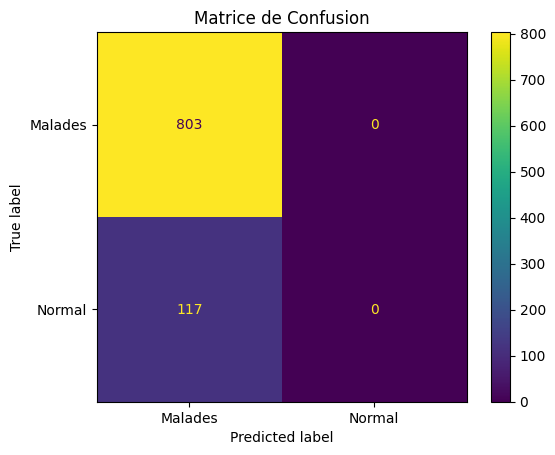

In [218]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=img_generator_flow_valid.class_indices.keys())
disp.plot()
plt.title("Matrice de Confusion")
plt.savefig("confusion_matrix.png")
mlflow.log_artifact("confusion_matrix.png", artifact_path='model')

In [219]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

seuils = np.arange(0.0, 1.0, 0.01)

# Fonction pour calculer la F1-score pour un seuil donné
def calculer_f1_score(y_true, y_pred_prob, seuil):
    y_pred = (y_pred_prob >= seuil).astype(int)
    return f1_score(y_true, y_pred)

# Trouver le seuil qui maximise la F1-score
f1_scores = [calculer_f1_score(y_true, y_pred, seuil) for seuil in seuils]
seuil_optimal = seuils[np.argmax(f1_scores)]

print("Seuil optimal :", seuil_optimal)
print("F1-score pour le seuil optimal :", max(f1_scores))
mlflow.log_metric("optimal_threshold", seuil_optimal)
mlflow.log_metric("optimal_f1_score", max(f1_scores))

Seuil optimal : 0.0
F1-score pour le seuil optimal : 0.2256509161041466


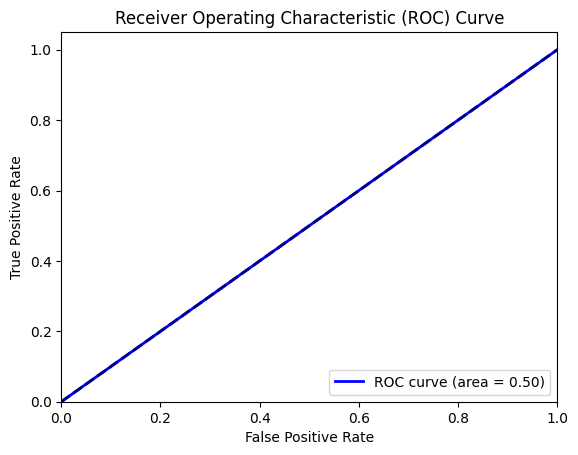

In [220]:
# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
mlflow.log_artifact("roc_curve.png", artifact_path='model')

In [221]:
mlflow.end_run()

🏃 View run hilarious-lamb-775 at: https://david-rem-jedha-final-project-mlops.hf.space/#/experiments/2/runs/50bdbe374b7e445bba690dac57ff0b35
🧪 View experiment at: https://david-rem-jedha-final-project-mlops.hf.space/#/experiments/2
